# Run Theta Model
Steps:
1. Read dataset file
2. Create training & test data
3. Build LSTM model
4. Forecast Theta lines

In [92]:
# Import file and data libraries
import math
import pickle
import numpy as np
import pandas as pd 
import collections
import matplotlib.pyplot as plt
from pprint import pprint

# Import LSTM layers form the Keras library
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential

# Import Matthews Correlation Coefficient module (MCC)
from sklearn.metrics import matthews_corrcoef

import warnings
warnings.filterwarnings("ignore")

# Step 1. Read dataset file

In [93]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [94]:
# Read X & Y datasets from Pickle file, along with the metadata
dataset_path = "/content/drive/My Drive/Colab Notebooks/3. Code/3. Compare/Dataset/"

with open(dataset_path + "Dataset Theta.pickle", "rb") as f:
    X = pickle.load(f)
    Y = pickle.load(f)  # Contains Y_Avg, X_Last, Y_Diff, Y_Band, Y_Gap, Y_Days, Y_Avg_Norm, X_Last_Norm, Y_Band_Norm
    Metadata = pickle.load(f) # Contains the Company ID, ticker, sector and Dataset ID
f.close()

In [95]:
# Check number of datasets
print(len(X), len(Y), len(Metadata))

3989 3989 3989


In [96]:
# Check Theta Lines (the last 2 rows are NaN because Theta uses 2 level differentiation)
X[0]
# The coefficients for each Theta line:
# Theta 1: 0.25, Theta 2 = 0.5, Theta 3 = 0.75
# Theta 4: 1.25, Theta 5 = 1.5, Theta 6 = 2

Date    HL_Avg     Volume  HL_Avg_Norm  Volume_Norm    Theta1  \
1824 1988-03-02  0.395089  292320000     0.001910     0.039388  0.001947   
1825 1988-03-03  0.408482  473760000     0.001984     0.063835  0.001970   
1826 1988-03-04  0.412946  209440000     0.002009     0.028220  0.002064   
1827 1988-03-07  0.420759  207200000     0.002052     0.027918  0.002020   
1828 1988-03-08  0.415179  144480000     0.002021     0.019467  0.002049   
...         ...       ...        ...          ...          ...       ...   
3083 1993-02-23  0.487723  194073600     0.002422     0.026150  0.002325   
3084 1993-02-24  0.473214  286563200     0.002342     0.038612  0.002407   
3085 1993-02-25  0.482143  167227200     0.002391     0.022532  0.002368   
3086 1993-02-26  0.475446  294884800     0.002354     0.039733       NaN   
3087 1993-03-01  0.474330  119302400     0.002348     0.016075       NaN   

        Theta2    Theta3    Theta4    Theta5    Theta6  
1824  0.001935  0.001923  0.001898  0.001886  0.001861  
1825  0.001975  0.001980  0.001989  0.001993  0.002003  
1826  0.002046  0.002027  0.001990  0.001972  0.001935  
1827  0.002030  0.002041  0.002063  0.002074  0.002095  
1828  0.002040  0.002030  0.002012  0.002003  0.001984  
...        ...       ...       ...       ...       ...  
3083  0.002357  0.002390  0.002454  0.002487  0.002552  
3084  0.002385  0.002363  0.002320  0.002299  0.002256  
3085  0.002376  0.002383  0.002399  0.002407  0.002422  
3086       NaN       NaN       NaN       NaN       NaN  
3087       NaN       NaN       NaN       NaN       NaN  

[1264 rows x 11 columns]

In [97]:
# Check that the Y dataset has the normalised HL Avg and normalised X Last Price
Y[0] # Contains Y_Avg, X_Last, Y_Diff, Y_Band, Y_Gap, Y_Days, Y_Avg_Norm, X_Last_Norm, Y_Band_Norm

array([0.48337050000000004, 0.4743305, 1.9058441318869541, 'U1', 65, 5,
       0.0023979612733380485, 0.0023480111716386197, 'U1'], dtype=object)

# Step 2. Create training & test data

In [98]:
# Only use the first 1000 datasets because only the first 1000 have Theta lines
# First 700 are training datasets: 1000 days X + 3 months gap + 5 days Y
# Last 300 are test datasets: same allocation
X_Theta2_Train_List = [X[i][:1000]["Theta2"] for i in range(700)]
X_Theta2_Test_List  = [X[i][:1000]["Theta2"] for i in range(700,1000)]
Y_Theta2_Train_List = [np.average(X[i][1066:1071]["Theta2"]) for i in range(700)]
X_Theta5_Train_List = [X[i][:1000]["Theta5"] for i in range(700)]
X_Theta5_Test_List  = [X[i][:1000]["Theta5"] for i in range(700,1000)]
Y_Theta5_Train_List = [np.average(X[i][1066:1071]["Theta5"]) for i in range(700)]
X_Test_List = [X[i][:1000]["HL_Avg_Norm"] for i in range(700,1000)]
Y_Test_List = [np.average(X[i][1066:1071]["HL_Avg_Norm"]) for i in range(700,1000)]

# Convert to Numpy array 
X_Theta2_Train = np.array([np.array(X_Theta2_Train_List[i]) for i in range(700)])
X_Theta2_Test  = np.array([np.array(X_Theta2_Test_List[i]) for i in range(300)])
Y_Theta2_Train = np.array([np.array(Y_Theta2_Train_List[i]) for i in range(700)])
X_Theta5_Train = np.array([np.array(X_Theta5_Train_List[i]) for i in range(700)])
X_Theta5_Test  = np.array([np.array(X_Theta5_Test_List[i]) for i in range(300)])
Y_Theta5_Train = np.array([np.array(Y_Theta5_Train_List[i]) for i in range(700)])
X_Test  = np.array([np.array(X_Test_List[i]) for i in range(300)])
Y_Test  = np.array([np.array(Y_Test_List[i]) for i in range(300)])

print(X_Theta2_Train.shape, X_Theta2_Test.shape, Y_Theta2_Train.shape, Y_Test.shape)

(700, 1000) (300, 1000) (700,) (300,)


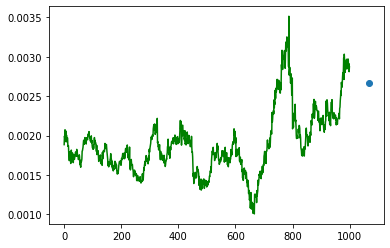

In [99]:
plt.plot(X_Theta5_Train[0], color="green")
plt.plot(1066,Y_Theta5_Train[0], marker="o")
plt.show()

# Step 3. Build & Train LSTM Models

In [126]:
File_Name = "Theta25 P1000 0DL 0DO 1e MSE.csv"

In [127]:
# Create LSTM Model for Theta3 and train it
LSTM_Output = 71 # 66 + 5 = 71 days look ahead
model2 = Sequential() 
model2.add(LSTM(units = LSTM_Output, input_shape = (X_Theta2_Train.shape[1], 1))) 
#model2.add(Dropout(0.2))
#model2.add(Dense(units = LSTM_Output))
#model2.add(Dropout(0.2))
#model2.add(Dense(units = LSTM_Output))
model2.compile(optimizer = "adam", loss = "mean_absolute_error") 
model2.fit(X_Theta2_Train, Y_Theta2_Train, epochs = 1, batch_size = 32)

22/22 [==============================] - 10s 394ms/step - loss: 0.0822


In [128]:
# Create LSTM Model for Theta3 and train it
LSTM_Output = 71 # 66 + 5 = 71 days look ahead
model5 = Sequential() 
model5.add(LSTM(units = LSTM_Output, input_shape = (X_Theta5_Train.shape[1], 1)))
#model5.add(Dropout(0.2))
#model5.add(Dense(units = LSTM_Output))
#model5.add(Dropout(0.2))
#model5.add(Dense(units = LSTM_Output))
model5.compile(optimizer = "adam", loss = "mean_absolute_error") 
model5.fit(X_Theta5_Train, Y_Theta5_Train, epochs = 1, batch_size = 32)

22/22 [==============================] - 10s 365ms/step - loss: 0.0756


# Step 4. Forecast Theta lines

In [129]:
# Forecast the Theta lines
F_Theta2_Test = model2.predict(X_Theta2_Test)
F_Theta5_Test = model5.predict(X_Theta5_Test)

In [130]:
print(Y_Test[0], np.average(F_Theta2_Test[0][-5:]), np.average(F_Theta5_Test[0][-5:]))

0.1772782398603322 0.13145672 0.24224643


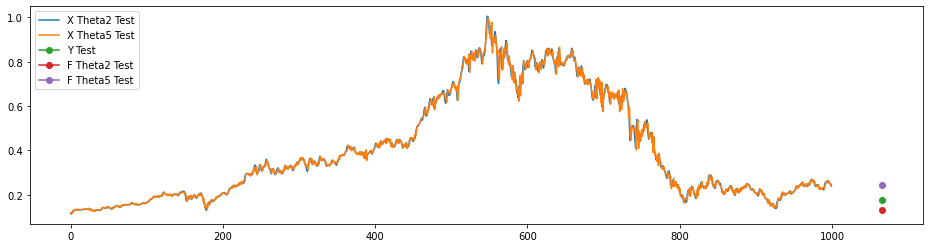

In [131]:
DS = 0
plt.figure(figsize=(16, 4))
plt.plot(X_Theta2_Test[DS], label="X Theta2 Test")
plt.plot(X_Theta5_Test[DS], label="X Theta5 Test")
plt.plot(1066, Y_Test[DS],marker="o", label="Y Test")
plt.plot(1066, np.average(F_Theta2_Test[DS][-5:]), marker="o", label="F Theta2 Test")
plt.plot(1066, np.average(F_Theta5_Test[DS][-5:]), marker="o", label="F Theta5 Test")
plt.legend(loc="upper left")
plt.show()

# Step 5. Convert forecast to price band

In [132]:
# Function to calculate 5% band i.e. 
#     0 to 5% = U1 (including 0), 5 to 10% = U2, 10 to 15% = U3, 15 to 20% = U4, >= U5.
#     <0 to -5% = D1, -5 to -10% = D2, -10 to -15% = D3, -15 to -20 = D4, <-20% = D5.
def calc_band(input_pct):
    if input_pct > 20: 
        band = 5
        prefix = 'U'
    elif input_pct < -20: 
        band = 5
        prefix = "D"
    elif input_pct >= 0:
        band = math.floor(input_pct / 5) + 1 # Floor(1/5) is 0 so to make it Band 1 we need to add 1
        prefix = "U"
    elif input_pct < 0:
        band = math.floor(input_pct / 5) # Floor(-1/5) is -1 so no need to add 1
        prefix = "D"
    else: # NaN for example
        band = 0
        prefix = "E" # Error band
    return prefix + str(abs(band))

In [133]:
# Calculate the 1 week average of the forecasted Theta prices
# Then calcualte the difference to the normalised X last price
# Then calculate the price band
Y_Band_List = []
F_Band_List = []
for DS in range(300):
    # Average the two Thetas
    F_Theta2_Avg = np.average(F_Theta2_Test[DS][-5:])
    F_Theta5_Avg = np.average(F_Theta5_Test[DS][-5:])
    F_Avg = (F_Theta2_Avg + F_Theta5_Avg)/2
    Y_Avg = Y_Test[DS]

    # Calculate the difference to the normalised X last price
    X_Last = X_Test[DS][999]
    Y_Diff = Y_Avg - X_Last
    F_Diff = F_Avg - X_Last

    # Calculate the price band
    Y_Band = calc_band(Y_Diff*100)
    F_Band = calc_band(F_Diff*100)
    Y_Band_List.append(Y_Band)
    F_Band_List.append(F_Band)

# Step 6. Evaluate the result

In [134]:
# Compare the actual price band and the forecasted band from Theta lines
F_Status_List = []
for DS in range(300):
    F_Status = 1 if Y_Band_List[DS] == F_Band_List[DS] else 0
    F_Status_List.append(F_Status)
    #print(Y_Band_List[DS], F_Band_List[DS], F_Status)
sum(F_Status_List)

52

In [135]:
matthews_corrcoef(Y_Band_List, F_Band_List) 

-0.006337188957767197

In [136]:
# Distribution of forecasted bands
counter=collections.Counter(Y_Band_List)
pprint(dict(counter))
counter=collections.Counter(F_Band_List)
pprint(dict(counter))

{'D1': 110, 'D2': 15, 'D3': 2, 'D5': 2, 'U1': 138, 'U2': 28, 'U3': 3, 'U5': 2}
{'D1': 120, 'D2': 73, 'D3': 61, 'D4': 20, 'D5': 14, 'U1': 11, 'U2': 1}


# Step 7. Save output to CSV file

In [137]:
Output_File = ""
for i in range(len(Y_Band_List)):
    Output = Y_Band_List[i] + "," +  F_Band_List[i] + "," + str(F_Status_List[i]) + "\n"
    Output_File = Output_File + Output   

In [138]:
# print(output_file)
File_Path = "/content/drive/My Drive/Colab Notebooks/3. Code/4. Combine/Output/"
f = open(File_Path + File_Name, "w")
f.write(Output_File)
f.close()